# Named Entity Recognition in Practise

In the previous tutorials we learnt about various Information Extraction techniques. We also learnt about Named Entity Recognition and Conditional Random Fields.

In this tutorial, we will augment our knowledge about CRF and see how we can use it in practise. We will be using an annotated open database from kaggle. The benefit of using this dataset is that the data is annotated with all the sentences tokenized, the parts of speech(pos) assigned various features from the sentence already extracted for us. So in other words, all the lengthy and time taking aspects of data sciences served to us ready-made on a platter :) The dataset uses sentences from Reuters news.

## About dataset

The dataset has two files:
    * ner_dataset.csv : This file has 4 columns.
        * The first column indicates the sentence delimiter
        * The second column indicates the words constituting the sentence
        * The third column indicates the POS tags for the word
        * The fourth column indicates the assigned tag in IOB format (Explained below)
    * ner.csv : This dataset has 25 columns. These columns are basically the features extracted out the the raw news articles. The features include current words, next word, the word next to next word etc. So it basically tries to  extracts out all the relations between a word and its neighbouring words. (Psst: Do you smell correlated features ?).

The dataset has in total __47959__ Sentences, __1048575__ words, __1048575__ pos tags and __1048575__ tags

Following are the entities tagged in the dataset:

geo - Geographical Entity

org = Organization

per = Person

gpe = Geopolitical Entity

tim = Time indicator

art = Artifact

eve = Event

nat = Natural Phenomenon


### IOB Tagging
IOB tagging or Insite-Outside-Beginning tagging is a way of demarkating a particular entity, as to its position while chunking. Here is what it means:
    * The I-prefix indicates that the tag was found inside the chunk
    * The O-prefix indicates that the tag was found outside the chunk
    * The B-prefix indicates that the tag was found at the beginning of the chunk
        
For Example:

Sachin - B-per

is - 0

going - 0

to - 0

New - B-geo

Delhi - I-geo

## NER using CRF

### Dataset exploration

In [84]:
import pandas as pd

In [85]:
# Read the file with the given encoding and do not throw any error, ignore it.
df = pd.read_csv("../data/ner_dataset.csv",encoding = "ISO-8859-1",error_bad_lines=False)

#The following shows the first 5 rows of the dataset
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [86]:
# Let us get to know our dataset better

# Shape of the dataframe
print("########### Shape ###############")
print(df.shape)
print("#################################")
print("\n")
#Overall statistics of the data-frame
print("########### Dataframe Stats ###############")
print(df.count())
print("###########################################")

########### Shape ###############
(1048575, 4)
#################################


########### Dataframe Stats ###############
Sentence #      47959
Word          1048575
POS           1048575
Tag           1048575
dtype: int64
###########################################


In [87]:
# Let's try to analyze how many Tags(Entities) are there in the dataset
agg = df.groupby("Tag").count()
print(agg)

       Sentence #    Word     POS
Tag                              
B-art          18     402     402
B-eve          10     308     308
B-geo        3335   37644   37644
B-gpe        2989   15870   15870
B-nat          11     201     201
B-org        2752   20143   20143
B-per        4019   16990   16990
B-tim         515   20333   20333
I-art           0     297     297
I-eve           0     253     253
I-geo           0    7414    7414
I-gpe           0     198     198
I-nat           0      51      51
I-org           0   16784   16784
I-per           0   17251   17251
I-tim           0    6528    6528
O           34310  887908  887908


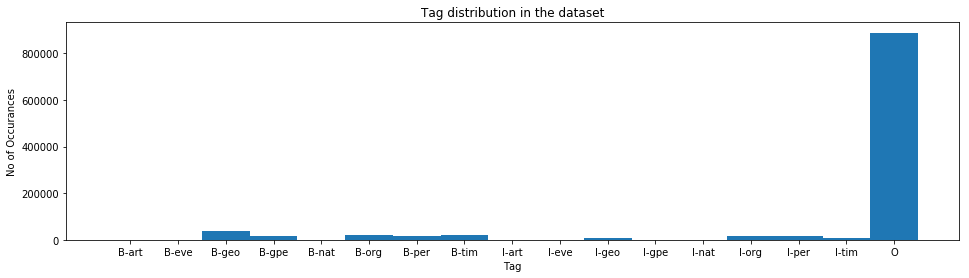

In [88]:
import matplotlib.pyplot as plt

# Let's plot a bar graph showing the Entities and the number of words each of them have
fig, ax = plt.subplots(figsize=(16,4))
plt.bar(agg.index,agg.Word,width=1)
plt.xlabel('Tag', fontsize=10)
plt.ylabel('No of Occurances', fontsize=10)
#plt.xticks(5, label, fontsize=5, rotation=30)
plt.title('Tag distribution in the dataset')
plt.show()


Now lets take a look at the other data set file. As mentioned "ner.csv" is a feature engineered file which serves us all the features of the articles in a text file. Let's see that it contains

In [89]:
dfRaw = pd.read_csv("../data/ner.csv",encoding = "ISO-8859-1",error_bad_lines=False)
dfRaw.head()

b'Skipping line 281837: expected 25 fields, saw 34\n'


,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,...,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,...,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,...,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,...,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


In [90]:
# As we see from the above cell, this dataset lists down all the feature-set extracted in the dataset.
# Let us see the count of number of examples in each feature set
dfRaw.count()

Unnamed: 0         1050795
lemma              1050795
next-lemma         1050795
next-next-lemma    1050795
next-next-pos      1050795
next-next-shape    1050795
next-next-word     1050795
next-pos           1050795
next-shape         1050794
next-word          1050794
pos                1050794
prev-iob           1050794
prev-lemma         1050794
prev-pos           1050794
prev-prev-iob      1050794
prev-prev-lemma    1050794
prev-prev-pos      1050794
prev-prev-shape    1050794
prev-prev-word     1050794
prev-shape         1050794
prev-word          1050794
sentence_idx       1050794
shape              1050794
word               1050794
tag                1050794
dtype: int64

### Preprocessing

Okay, now let us start preprocessing our data so that we can feed it to CRF algorithm.

In [91]:
# We fill all the NA (null) values
df = df.fillna(method='ffill')

In [92]:
# Import the crf_suite library
import sklearn_crfsuite

The following code is taken from sklearn_crfsuite website. This illustrates how the crfsuite will take its feature vector as input for processing.

In [93]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

### Explanation of code

If you look at the code carefully, you will be able to understand the methods above are expecting a list of tuples as an input parameter to convert it into pre-determined feature set. Let us take a look at all the methods, one by one:

    *sent2features : It takes a sentence as an input and calls word2features()
    *word2features : As the name suggests, it takes the words and then converts it into features. The features are like whether or not the word is in upper case, if its a digit or not etc.
    *sent2labels : It will extract out the labels (Tags) from the input data

To convert the dataframe example into a format acceptable by the crfsuite feature conversion methods, we will write a converter function of our own. This will in essence map the dataframe into the input that is needed by the methods of crfsuite algorithm.

In [94]:
class Sentence(object):
    data = None
    sent = None
    grouped = None
    def __init__(self, data):
        self.data = data
        # Take the data, extract out the word, part of speech associated and the Tag assigned and convert it
        # into a list of tuples.
        list_vals = lambda row: [(word, pos, tag) for word, pos, tag in list(zip(row['Word'],row['POS'],row['Tag']))]
        
        # Group the collected values according to the Sentence # column in the dataframe so that all the words
        # in a sentence are gouped together
        self.grouped = self.data.groupby('Sentence #').apply(list_vals)
        
        #Add the rows to the 'sent' list.
        self.sent = [row for row in self.grouped]

In [95]:
# We will now pass our dataset to the Sentence class that we just wrote which will then convert the dataset for 
# furthur processing
sObject = Sentence(df)
sentences = sObject.sent

In [96]:
brings# Load the train_test_split model so that we can split the data into training data and test data
from sklearn.model_selection import train_test_split

# Convert all the sentences into features
X = [sent2features(s) for s in sentences]

#Get all the labels from the dataset
y = [sent2labels(s) for s in sentences]

# Split the data into Training data and Testing data. We keep 33% of the data/rows for testing our learned model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

### Conditon Random Field

Now since we have all the necessary parts ready, let us feed the prepared data into CRF algorithm

In [97]:
import sklearn_crfsuite

crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=0.1, c2=0.1,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

Let us inspect the model weight using the popular eli5 library

In [98]:
import eli5
eli5.show_weights(crf, top=10)

From \ To,O,B-art,I-art,B-eve,I-eve,B-geo,I-geo,B-gpe,I-gpe,B-nat,I-nat,B-org,I-org,B-per,I-per,B-tim,I-tim
O,3.608,0.169,-3.957,0.383,-3.528,0.981,-7.952,0.286,-3.885,0.583,-2.591,0.88,-6.781,1.374,-6.055,1.58,-6.494
B-art,-0.338,0.0,6.358,0.0,-0.099,-0.434,-1.612,-1.126,-0.269,0.0,0.0,0.048,-1.906,-2.376,-1.817,0.311,-0.991
I-art,-0.337,-0.597,6.181,0.0,0.0,-0.262,-1.476,-0.835,0.0,0.0,0.0,-0.972,-1.358,-1.251,-1.595,-1.291,-0.85
B-eve,-0.754,0.0,-0.015,-0.231,5.842,-1.184,-1.476,-1.015,-0.5,-0.152,0.0,-1.455,-1.371,-1.992,-1.617,0.395,-1.047
I-eve,0.232,0.0,0.0,-1.962,5.938,-0.701,-0.947,-0.151,0.0,0.0,0.0,-0.768,-0.942,-1.348,-1.136,-1.759,-0.964
B-geo,0.106,0.0,-2.186,-1.24,-1.915,-4.169,3.996,0.033,-3.44,-0.378,-1.05,-0.565,-4.611,-2.306,-4.647,1.105,-3.478
I-geo,-0.003,1.259,-1.214,-0.244,-1.156,-2.852,3.275,-1.174,-2.164,0.0,-0.332,-0.648,-3.324,-1.316,-3.503,0.527,-2.641
B-gpe,0.535,-1.168,-1.624,-1.314,-2.354,-0.399,-4.961,-5.669,4.454,-0.44,-0.611,0.774,-4.967,-0.715,-4.312,-0.495,-3.0
I-gpe,-0.035,0.0,0.0,0.0,0.0,-0.007,-1.591,-0.523,4.887,0.0,0.0,-0.954,-0.936,-0.114,-0.92,-0.805,-0.369
B-nat,-1.088,0.0,0.0,0.0,0.0,-0.446,-0.733,-0.699,0.0,-0.305,6.03,-0.408,-0.608,-1.142,-1.319,-0.653,-0.319


Okay... Let us run our learned model on the reserved test dataset(33% of the dataset. Remember?) and check the accuracy of our model

In [100]:
Y = crf.predict(X_test)

# Now lets run the prediction with some metrics

In [122]:
# Import crfsuite metrics
from sklearn_crfsuite import metrics

# Draw the metrics of the Test Data with that of the predicted data
print(metrics.flat_classification_report(y_test, Y))

              precision    recall  f1-score   support

       B-art       0.42      0.11      0.18       143
       B-eve       0.58      0.42      0.48       106
       B-geo       0.86      0.91      0.88     12447
       B-gpe       0.97      0.94      0.95      5284
       B-nat       0.82      0.41      0.55        78
       B-org       0.80      0.73      0.76      6615
       B-per       0.85      0.82      0.84      5652
       B-tim       0.93      0.88      0.90      6856
       I-art       0.11      0.03      0.05       105
       I-eve       0.38      0.25      0.30        93
       I-geo       0.82      0.80      0.81      2520
       I-gpe       0.90      0.62      0.74        69
       I-nat       1.00      0.39      0.56        23
       I-org       0.81      0.80      0.81      5597
       I-per       0.85      0.90      0.87      5674
       I-tim       0.83      0.75      0.79      2207
           O       0.99      0.99      0.99    291891

   micro avg       0.97   

You can see from the figure above, the Precision, Recall and the F1 score of the model performance. 

## Conclusion

In this tutorial, we saw how we can train CRF algorithm on a dataset and train it to extract out the desired entities from the dataset. We also saw how good it is in identifying the named entities from the dataset. The next text tutorial, we will see how to perform NER on the same dataset using Deep-Learning.

# Keras in Action



In [ ]:
# Import pandas library and fill the null values
import numpy as np
import pandas as pd
df = pd.read_csv("../data/ner_dataset.csv",encoding = "ISO-8859-1",error_bad_lines=False)
df = df.fillna(method="ffill")

# Same as last tutorial. To extract out values in Word, Tag and POS columns
class Sentence(object):
    data = None
    sent = None
    grouped = None
    def __init__(self, data):
        self.data = data
        list_vals = lambda row: [(word, pos, tag) for word, pos, tag in list(zip(row['Word'],row['POS'],row['Tag']))]
        self.grouped = self.data.groupby('Sentence #').apply(list_vals)
        self.sent = [row for row in self.grouped]
        
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
        
# The input vector needs to be of equal & fixed length as defined by 'max_len'. 
# We will use padding the sentences to 'max_len'
max_len = 50

# Get the words in form of a list and add the string "ENDPAD" at the end of the lsit
words = list(set(df["Word"].values))
n_words = len(words)
words.append("ENDPAD")

# Get all the tags as a list
tags = list(set(df["Tag"].values))

# As in the last turorial(Ner with CRF) we will reconstruct the input vectors
sObject = Sentence(df)
sentences = sObject.sent

word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}


# We will be using keras built in function 'pad_sequences' to pad the input vectors to 'max_lan'
# This will ensure that all sequences in a list have the same length
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)

# Using the built-in function to_categorical to convert a class vector (integers) to binary class matrix.
from keras.utils import to_categorical
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
y = [to_categorical(i, num_classes=len(tags)) for i in y]


# Load the train_test_split model so that we can split the data into training data and test data
from sklearn.model_selection import train_test_split

# Convert all the sentences into features
#X = [sent2features(s) for s in sentences]

#Get all the labels from the dataset
#y = [sent2labels(s) for s in sentences]

# Split the data into Training data and Testing data. We keep 33% of the data/rows for testing our learned model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

# Import Keras related modules and build the model
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

# We will now be building the model

#Input is used to instantiate a Keras tensor. A Keras tensor is a tensor object from the underlying backend(Tensorflow)
# which we augment with certain attributes that allow us to build a Keras model just buy knowing the inputs and 
# output of the model
input = Input(shape=(max_len,))

# 'Embedding' turns positive integers into dense vectors of a fixed size
# Therefore, we supply to it the input/output dimesions, and the input length
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)

model = Dropout(0.1)(model)

#Initialize bi-directional LSTM cells
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)

# Initialize a time distributed layer while building the sequential model
out = TimeDistributed(Dense(len(tags), activation="softmax"))(model)  # softmax output layer
model = Model(input, out)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
trained = model.fit(X_train, np.array(y_train), batch_size=32, epochs=5, validation_split=0.1, verbose=1)


p = model.predict(np.array([X_test[1234]]))
p = np.argmax(p,axis=1)

# Print the predictions of the sample # 1234
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w, pred in zip(X_test[1234], p[0]):
    try:
        print("{:15}: {}".format(words[w], tags[pred]))
    except:
        pass
    


# Conclusion

In this tutorial, we saw how can we train a bi-LSTM network to extract named entities from a dataset.

This brings us to the end of the tutorial on Information Extraction and Named Entity Recognition. We sincerly hope that this tutorial would have helped in gaining a better understanding of the subject.

Happy Learning !